In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from factorization.data.synthetic import Sampler, SamplerConfig
from factorization.models.mlp import ModelConfig, Model

torch.random.manual_seed(0)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data

Simple interface to generate all the data setup described in the overleaf

In [3]:
# %% Instantiation

alpha = 0.6
input_size = 60
output_size = 24

all_ps = [
    torch.tensor([3, 2, 2, 5], device=DEVICE),
    torch.tensor([2, 6, 5], device=DEVICE),
    torch.tensor([15, 2], device=DEVICE),
]
all_qs = [(alpha * p).ceil().int() for p in all_ps]

weights = None

sparse_config = SamplerConfig(
    input_divisors=all_ps,
    alpha=alpha,
    weights=weights,
    epsilon=1e-7,
)
sampler = Sampler(sparse_config)

deterministic_config = SamplerConfig(
    input_divisors=[[input_size]],
    output_divisors=[[output_size]],
    epsilon=1e-7,
)
deterministic_sampler = Sampler(deterministic_config)

random_config = SamplerConfig(
    input_size=input_size,
    output_size=output_size,
    random=True,
)
random_sampler = Sampler(random_config)

/home/vivc/Code/memory-theory/src/factorization/data/synthetic.py:198: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.input_divisors = [torch.tensor(p, device=DEVICE) for p in self.input_divisors]


In [5]:
random_sampler.sample_in_parallel(20).shape

TypeError: multinomial() got an unexpected keyword argument 'device'

## Model

To keep it simple, I take a MLP architecture that resembles a transformer without attention.

In [4]:
config = ModelConfig(
    input_size=input_size,
    output_size=output_size,
    emb_dim=32,
    ffn_dim=64,
    nb_layers=2,
)

model = Model(config)

AttributeError: 'ModelConfig' object has no attribute '__post_init__'

## training

In [ ]:
n_epochs = 0
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=.01)

n_train = (input_size * 2) // 3

backbone_sampler = random_sampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

losses = torch.empty(n_epochs)

inputs = torch.arange(input_size).to(int)
indices = torch.randperm(len(inputs))
train_inputs = inputs[indices[:n_train]]
test_inputs = inputs[indices[n_train:]]

outputs = backbone_sampler(inputs)
probas = backbone_sampler.probas

min_loss = F.cross_entropy(torch.log(probas), probas).item()

model.to(device)
inputs = inputs.to(device)
targets = outputs.to(device)

for epoch in range(n_epochs):
    # training
    with torch.no_grad():
        targets = backbone_sampler(train_inputs).to(device)

    logits = model(inputs)
    loss = F.cross_entropy(logits, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        loss = F.cross_entropy(logits, probas)
        losses[epoch] = loss.item() - min_loss

AttributeError: module 'torch.random' has no attribute 'choice'

In [ ]:
min_loss

2.777881383895874

[]

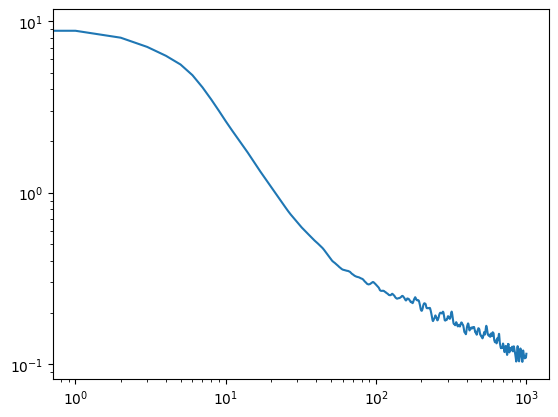

In [ ]:
plt.plot(losses)
plt.loglog()